<a href="https://colab.research.google.com/github/EmperoR1127/ml_project/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In recent years, an increasing number of internationals expect to get a working permission in US for various reasons. Quite a few of them, unfortunately, are denied. We feel it is important for candidates to predict the result prior submitting their applications, so we use machine learning algorithms to tackle this problem.

Another focus of this study is, with a comprehensive comparison and analysis, discussing the strength and limitations of different types of machine learning algorithm.

# Env setup
We need to import some packages to setup the working environment.

### Import packages

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
from scipy.io import arff
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Project root directory
PROJECT_ROOT_DIR = "/content/drive/My Drive/"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "Images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### Load the dataset

In [0]:
#load the dataset
path = PROJECT_ROOT_DIR + "Data/H-1B_Disclosure_RAW_Data.csv"
df = pd.read_csv(path, encoding='utf-8')
processed_data = df.copy()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The demonstration of supervised learning has 3 parts: feature engineering, training the models and experiments.

#Feature Engineering

We apply several feature engineering steps to the dataset, feature transformation; 
feature selection methods; 
since the dataset is highly skewed, we also tackle the class imbalance by resampling.

###Drop correlated columns and create new columns

In [0]:
processed_data = processed_data.drop(["CASE_NUMBER", "VISA_CLASS", 
                                        "EMPLOYER_NAME", "EMPLOYER_STATE","EMPLOYER_POSTAL_CODE", 
                                        "EMPLOYER_CITY", "EMPLOYER_BUSINESS_DBA", 
                                        "EMPLOYER_COUNTRY", "EMPLOYER_PROVINCE", "EMPLOYER_ADDRESS", 
                                        "EMPLOYER_PHONE", "EMPLOYER_PHONE_EXT", 
                                        "AGENT_ATTORNEY_NAME", "AGENT_ATTORNEY_CITY", "AGENT_ATTORNEY_STATE",
                                        "JOB_TITLE", "SOC_NAME",
                                        "PW_SOURCE", "PW_SOURCE_YEAR", "PW_SOURCE_OTHER", "WAGE_RATE_OF_PAY_FROM",
                                        "WAGE_RATE_OF_PAY_TO", "WAGE_UNIT_OF_PAY",
                                        "WORKSITE_CITY", "WORKSITE_COUNTY", "WORKSITE_POSTAL_CODE", 
                                        "ORIGINAL_CERT_DATE", "PUBLIC_DISCLOSURE_LOCATION"], axis=1)
#format EMPLOYMENT_START_DATE and EMPLOYMENT_END_DATE
processed_data['CASE_SUBMITTED'] = pd.to_datetime(processed_data['CASE_SUBMITTED'],infer_datetime_format=True,errors='coerce')
processed_data['DECISION_DATE'] = pd.to_datetime(processed_data['DECISION_DATE'],infer_datetime_format=True,errors='coerce')
processed_data['EMPLOYMENT_START_DATE'] = pd.to_datetime(processed_data['EMPLOYMENT_START_DATE'],infer_datetime_format=True,errors='coerce')
processed_data['EMPLOYMENT_END_DATE'] = pd.to_datetime(processed_data['EMPLOYMENT_END_DATE'],infer_datetime_format=True,errors='coerce')
#drop NaT rows because we can't "guess" the specific date
processed_data = processed_data[processed_data.CASE_SUBMITTED != 'NaT']
processed_data = processed_data[processed_data.DECISION_DATE != 'NaT']
processed_data = processed_data[processed_data.EMPLOYMENT_START_DATE != 'NaT']
processed_data = processed_data[processed_data.EMPLOYMENT_END_DATE != 'NaT']
#add one column as EMP_PERIOD, and drop EMPLOYMENT_START_DATE and EMPLOYMENT_END_DATE
processed_data['EMP_PERIOD'] = processed_data['EMPLOYMENT_END_DATE'] - processed_data['EMPLOYMENT_START_DATE']
processed_data['EMP_PERIOD'] = processed_data['EMP_PERIOD']/np.timedelta64(1,'Y')
#train_set = train_set[train_set.EMP_PERIOD != '-']
processed_data['EMP_PERIOD'] = processed_data['EMP_PERIOD'].astype(float)
#add one column as PROCESS_TIME, indicating processing time of visa application
processed_data['PROCESS_TIME'] = processed_data['DECISION_DATE'] - processed_data['CASE_SUBMITTED']
processed_data['PROCESS_TIME'] = processed_data['PROCESS_TIME'].map(lambda x: str(x)[:1])
processed_data['PROCESS_TIME'] = processed_data['PROCESS_TIME'].astype(float)
processed_data = processed_data.drop(["EMPLOYMENT_START_DATE", "EMPLOYMENT_END_DATE"], axis=1)
processed_data = processed_data.drop(["CASE_SUBMITTED", "DECISION_DATE"], axis=1)

#concatenate the first 2 digit of column SOC_CODE and NAIC_CODE
processed_data['SOC_CODE'] = processed_data['SOC_CODE'].map(lambda x: str(x)[:2])
processed_data['NAICS_CODE'] = processed_data['NAICS_CODE'].map(lambda x: str(x)[:2])
#remove impurity in the column
processed_data = processed_data[processed_data.PW_UNIT_OF_PAY != 'N']
processed_data = processed_data[processed_data.PREVAILING_WAGE != 'N']
#according to google, there are 2080 working hours per year
pw_unit_column = {"Year":1, "Hour":2080, "Month":12, "Week":52, "Bi-Weekly":26}
processed_data['PW_UNIT_OF_PAY'] = processed_data['PW_UNIT_OF_PAY'].replace(pw_unit_column)
#remove ',' in the column value
processed_data['PREVAILING_WAGE'] = processed_data['PREVAILING_WAGE'].astype('str')
processed_data['PREVAILING_WAGE'] = processed_data.PREVAILING_WAGE.str.replace(',','')
processed_data['PREVAILING_WAGE'] = processed_data['PREVAILING_WAGE'].astype('float')
#add one column as ANNUAL_SALARY
processed_data['ANNUAL_SALARY'] = processed_data['PREVAILING_WAGE'] * processed_data['PW_UNIT_OF_PAY']
processed_data = processed_data.drop(["PREVAILING_WAGE", "PW_UNIT_OF_PAY"], axis=1)


### Deal with noise, missing values, numerical and categorical data

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
original_set = processed_data.drop(["CASE_STATUS"], axis=1)
original_labels = processed_data[["CASE_STATUS"]].copy()
original_set_num = original_set.drop(["AGENT_REPRESENTING_EMPLOYER", "SOC_CODE", "NAICS_CODE",
                                "FULL_TIME_POSITION", "PW_WAGE_LEVEL", "H1B_DEPENDENT", "WILLFUL_VIOLATOR",
                                "SUPPORT_H1B", "LABOR_CON_AGREE", "WORKSITE_STATE"], axis=1)
original_set_cat = original_set.drop(["TOTAL_WORKERS","NEW_EMPLOYMENT","CONTINUED_EMPLOYMENT",
                                "CHANGE_PREVIOUS_EMPLOYMENT", "NEW_CONCURRENT_EMP", "CHANGE_EMPLOYER",
                                "AMENDED_PETITION", "EMP_PERIOD", "PROCESS_TIME",
                                "ANNUAL_SALARY"], axis=1)
#build the pipeline
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('std_scaler', StandardScaler()),])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),('cat', OneHotEncoder()),])
full_pipeline = ColumnTransformer([("num", num_pipeline, list(original_set_num)),("cat", cat_pipeline, list(original_set_cat)),])

#prepare the data
original_set = full_pipeline.fit_transform(original_set)

#prepare the target
encoder = LabelEncoder()
original_labels = encoder.fit_transform(original_labels)

#get columns after encoding
def get_feature_names(columnTransformer):
    output_features = []
    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)
    return output_features
column_names = get_feature_names(full_pipeline)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
original_set.shape

(20327, 122)

### Feature selection

Three feature selection methods: Boruta, L1-based and tree-based.

In [0]:
#get feature names after feature selection
def get_feature_names(X, col = column_names):
  try:
    mask = X.get_support() #list of booleans
  except AttributeError:
    mask = X.support_  #Boruta has different attributes from scikit-learn API
  new_features = [] # The list of your K best features
  for bool, feature in zip(mask, col):
    if bool:
      new_features.append(feature)
  return new_features

Boruta feature selection method

In [0]:
!pip install Boruta

     |████████████████████████████████| 61kB 4.2MB/s 


In [0]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
#Boruta feature selection
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

feat_selector = BorutaPy(rf, n_estimators='auto', random_state=1)
feat_selector.fit(original_set.toarray(), original_labels)
boruta_set = feat_selector.transform(original_set)
print("Dataset with " + str(original_set.shape[1]) + " features is reduced to " + str(boruta_set.shape[1])
      + " features after applying Boruta feature selection technique")
print(get_feature_names(feat_selector))

Dataset with 122 features is reduced to 5 features after applying Boruta feature selection technique
['PROCESS_TIME', 'ANNUAL_SALARY', 'SOC_CODE_15', 'H1B_DEPENDENT_N', 'H1B_DEPENDENT_Y']


L1-based and tree-based feature selection method

In [0]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
#L1-based feature selection
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter = 2000).fit(original_set, original_labels)
l_model = SelectFromModel(lsvc, prefit=True)
l1_set = l_model.transform(original_set)
print("Dataset with " + str(original_set.shape[1]) + " features is reduced to " + str(l1_set.shape[1])
      + " features after applying L1-based feature selection technique")
print(get_feature_names(l_model))

#tree-based feature selection
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(original_set, original_labels)
tb_model = SelectFromModel(clf, prefit=True)
tr_set = tb_model.transform(original_set)
print("Dataset with " + str(original_set.shape[1]) + " features is reduced to " + str(tr_set.shape[1])
      + " features after applying tree-based feature selection technique")
print(get_feature_names(tb_model))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Dataset with 122 features is reduced to 9 features after applying L1-based feature selection technique
['PROCESS_TIME', 'ANNUAL_SALARY', 'AGENT_REPRESENTING_EMPLOYER_Y', 'SOC_CODE_15', 'NAICS_CODE_54', 'FULL_TIME_POSITION_Y', 'H1B_DEPENDENT_Y', 'WILLFUL_VIOLATOR_N', 'SUPPORT_H1B_Y']
Dataset with 122 features is reduced to 16 features after applying tree-based feature selection technique
['TOTAL_WORKERS', 'NEW_EMPLOYMENT', 'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT', 'CHANGE_EMPLOYER', 'AMENDED_PETITION', 'EMP_PERIOD', 'PROCESS_TIME', 'ANNUAL_SALARY', 'AGENT_REPRESENTING_EMPLOYER_N', 'AGENT_REPRESENTING_EMPLOYER_Y', 'PW_WAGE_LEVEL_Level I', 'PW_WAGE_LEVEL_Level II', 'PW_WAGE_LEVEL_Level III', 'WORKSITE_STATE_CA', 'WORKSITE_STATE_NY']


### Deal with class imbalance

Three resampling techniques: oversampling, undersampling and balanced sampling.

In [0]:
import joblib
from collections import Counter
#load the datasets
original_set = joblib.load(PROJECT_ROOT_DIR + 'Data/' + 'original_set.gz')
boruta_set = joblib.load(PROJECT_ROOT_DIR + 'Data/' + 'boruta_set.gz')
l1_set = joblib.load(PROJECT_ROOT_DIR + 'Data/' + 'l1_set.gz')
tr_set = joblib.load(PROJECT_ROOT_DIR + 'Data/' + 'tr_set.gz')
#load the labels
original_labels = joblib.load(PROJECT_ROOT_DIR + 'Data/' + 'original_labels.gz')

Rebalance dataset with oversampling technique

In [0]:
from imblearn.over_sampling import RandomOverSampler

#rebalance the dataset using oversampling (random oversampling)
ros = RandomOverSampler(random_state=42)
ros_boruta_set, ros_boruta_labels = ros.fit_resample(boruta_set, original_labels)
print("Class distribution of oversampling with train_set_boruta " + str(sorted(Counter(ros_boruta_labels).items())))

ros_l1_set, ros_l1_labels = ros.fit_resample(l1_set, original_labels)
print("Class distribution of oversampling with train_set_l1 " + str(sorted(Counter(ros_l1_labels).items())))

ros_tr_set, ros_tr_labels = ros.fit_resample(tr_set, original_labels)
print("Class distribution of oversampling with train_set_tr " + str(sorted(Counter(ros_tr_labels).items())))

Class distribution of oversampling with train_set_boruta [(0, 20058), (1, 20058)]
Class distribution of oversampling with train_set_l1 [(0, 20058), (1, 20058)]
Class distribution of oversampling with train_set_tr [(0, 20058), (1, 20058)]


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Rebalance dataset with under-sampling technique

In [0]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
#rebalance the dataset using undersampling (nearest neightbours)
renn = RepeatedEditedNearestNeighbours()
renn_boruta_set, renn_boruta_labels = renn.fit_resample(boruta_set, original_labels)
print("Class distribution of undersampling with boruta_set " + str(sorted(Counter(renn_boruta_labels).items())))

renn_l1_set, renn_l1_labels = renn.fit_resample(l1_set, original_labels)
print("Class distribution of undersampling with l1_set " + str(sorted(Counter(renn_l1_labels).items())))

renn_tr_set, renn_tr_labels = renn.fit_resample(tr_set, original_labels)
print("Class distribution of undersampling with tr_set " + str(sorted(Counter(renn_tr_labels).items())))

Class distribution of undersampling with boruta_set [(0, 19484), (1, 269)]
Class distribution of undersampling with l1_set [(0, 19548), (1, 269)]
Class distribution of undersampling with tr_set [(0, 19606), (1, 269)]


Rebalance dataset with balanced sampling technique

In [0]:
from imblearn.combine import SMOTEENN
#rebalance the dataset using balanced sampling (SMOTEENN)
smote_enn = SMOTEENN(random_state=0)
smote_boruta_set, smote_boruta_labels = smote_enn.fit_resample(boruta_set, original_labels)
print("Class distribution of balanced sampling with boruta_set " + str(sorted(Counter(smote_boruta_labels).items())))

smote_l1_set, smote_l1_labels = smote_enn.fit_resample(l1_set, original_labels)
print("Class distribution of balanced sampling with l1_set " + str(sorted(Counter(smote_l1_labels).items())))

smote_tr_set, smote_tr_labels = smote_enn.fit_resample(tr_set, original_labels)
print("Class distribution of balanced sampling with tr_set " + str(sorted(Counter(smote_tr_labels).items())))

Class distribution of balanced sampling with boruta_set [(0, 16097), (1, 15546)]
Class distribution of balanced sampling with l1_set [(0, 16067), (1, 16140)]
Class distribution of balanced sampling with tr_set [(0, 19055), (1, 19077)]


### Split train and test set

In [0]:
#split the dataset into train and test set
from sklearn.model_selection import train_test_split

#1. split original_set and original_labels
original_set_train, original_set_test, original_labels_train, original_labels_test = train_test_split(original_set,original_labels, test_size=0.2, random_state=42)

#2. split ros_boruta_set and ros_boruta_labels
ros_boruta_set_train, ros_boruta_set_test, ros_boruta_labels_train, ros_boruta_labels_test = train_test_split(ros_boruta_set,ros_boruta_labels, test_size=0.2, random_state=42)
#3. split ros_l1_set and ros_l1_labels
ros_l1_set_train, ros_l1_set_test, ros_l1_labels_train, ros_l1_labels_test = train_test_split(ros_l1_set,ros_l1_labels, test_size=0.2, random_state=42)
#4. split ros_tr_set and ros_tr_labels
ros_tr_set_train, ros_tr_set_test, ros_tr_labels_train, ros_tr_labels_test = train_test_split(ros_tr_set,ros_tr_labels, test_size=0.2, random_state=42)

#5. split renn_boruta_set and renn_boruta_labels
renn_boruta_set_train, renn_boruta_set_test, renn_boruta_labels_train, renn_boruta_labels_test = train_test_split(renn_boruta_set,renn_boruta_labels, test_size=0.2, random_state=42)
#6. split renn_l1_set and renn_l1_labels
renn_l1_set_train, renn_l1_set_test, renn_l1_labels_train, renn_l1_labels_test = train_test_split(renn_l1_set,renn_l1_labels, test_size=0.2, random_state=42)
#7. split renn_tr_set and renn_tr_labels
renn_tr_set_train, renn_tr_set_test, renn_tr_labels_train, renn_tr_labels_test = train_test_split(renn_tr_set,renn_tr_labels, test_size=0.2, random_state=42)

#8. split smote_boruta_set and smote_boruta_labels
smote_boruta_set_train, smote_boruta_set_test, smote_boruta_labels_train, smote_boruta_labels_test = train_test_split(smote_boruta_set,smote_boruta_labels, test_size=0.2, random_state=42)
#9. split smote_l1_set and smote_l1_labels
smote_l1_set_train, smote_l1_set_test, smote_l1_labels_train, smote_l1_labels_test = train_test_split(smote_l1_set,smote_l1_labels, test_size=0.2, random_state=42)
#10. split smote_tr_set and smote_tr_labels
smote_tr_set_train, smote_tr_set_test, smote_tr_labels_train, smote_tr_labels_test = train_test_split(smote_tr_set,smote_tr_labels, test_size=0.2, random_state=42)


### Dump the dataset

In [0]:
#store original dataset
joblib.dump(original_set_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'original_set_train' + '.gz', compress=('gzip', 3))
joblib.dump(original_set_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'original_set_test' + '.gz', compress=('gzip', 3))
joblib.dump(original_labels_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'original_labels_train' + '.gz', compress=('gzip', 3))
joblib.dump(original_labels_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'original_labels_test' + '.gz', compress=('gzip', 3))

#store ros_boruta dataset
joblib.dump(ros_boruta_set_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_boruta_set_train' + '.gz', compress=('gzip', 3))
joblib.dump(ros_boruta_set_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_boruta_set_test' + '.gz', compress=('gzip', 3))
joblib.dump(ros_boruta_labels_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_boruta_labels_train' + '.gz', compress=('gzip', 3))
joblib.dump(ros_boruta_labels_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_boruta_labels_test' + '.gz', compress=('gzip', 3))

#store ros_l1 dataset
joblib.dump(ros_l1_set_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_l1_set_train' + '.gz', compress=('gzip', 3))
joblib.dump(ros_l1_set_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_l1_set_test' + '.gz', compress=('gzip', 3))
joblib.dump(ros_l1_labels_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_l1_labels_train' + '.gz', compress=('gzip', 3))
joblib.dump(ros_l1_labels_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_l1_labels_test' + '.gz', compress=('gzip', 3))

#store ros_tr dataset
joblib.dump(ros_tr_set_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_tr_set_train' + '.gz', compress=('gzip', 3))
joblib.dump(ros_tr_set_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_tr_set_test' + '.gz', compress=('gzip', 3))
joblib.dump(ros_tr_labels_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_tr_labels_train' + '.gz', compress=('gzip', 3))
joblib.dump(ros_tr_labels_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_tr_labels_test' + '.gz', compress=('gzip', 3))

#store renn_boruta dataset
joblib.dump(renn_boruta_set_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_boruta_set_train' + '.gz', compress=('gzip', 3))
joblib.dump(renn_boruta_set_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_boruta_set_test' + '.gz', compress=('gzip', 3))
joblib.dump(renn_boruta_labels_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_boruta_labels_train' + '.gz', compress=('gzip', 3))
joblib.dump(renn_boruta_labels_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_boruta_labels_test' + '.gz', compress=('gzip', 3))

#store renn_l1 dataset
joblib.dump(renn_l1_set_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_l1_set_train' + '.gz', compress=('gzip', 3))
joblib.dump(renn_l1_set_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_l1_set_test' + '.gz', compress=('gzip', 3))
joblib.dump(renn_l1_labels_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_l1_labels_train' + '.gz', compress=('gzip', 3))
joblib.dump(renn_l1_labels_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_l1_labels_test' + '.gz', compress=('gzip', 3))

#store renn_tr dataset
joblib.dump(renn_tr_set_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_tr_set_train' + '.gz', compress=('gzip', 3))
joblib.dump(renn_tr_set_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_tr_set_test' + '.gz', compress=('gzip', 3))
joblib.dump(renn_tr_labels_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_tr_labels_train' + '.gz', compress=('gzip', 3))
joblib.dump(renn_tr_labels_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_tr_labels_test' + '.gz', compress=('gzip', 3))

#store smote_boruta dataset
joblib.dump(smote_boruta_set_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_boruta_set_train' + '.gz', compress=('gzip', 3))
joblib.dump(smote_boruta_set_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_boruta_set_test' + '.gz', compress=('gzip', 3))
joblib.dump(smote_boruta_labels_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_boruta_labels_train' + '.gz', compress=('gzip', 3))
joblib.dump(smote_boruta_labels_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_boruta_labels_test' + '.gz', compress=('gzip', 3))

#store smote_l1 dataset
joblib.dump(smote_l1_set_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_l1_set_train' + '.gz', compress=('gzip', 3))
joblib.dump(smote_l1_set_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_l1_set_test' + '.gz', compress=('gzip', 3))
joblib.dump(smote_l1_labels_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_l1_labels_train' + '.gz', compress=('gzip', 3))
joblib.dump(smote_l1_labels_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_l1_labels_test' + '.gz', compress=('gzip', 3))

#store smote_tr dataset
joblib.dump(smote_tr_set_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_tr_set_train' + '.gz', compress=('gzip', 3))
joblib.dump(smote_tr_set_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_tr_set_test' + '.gz', compress=('gzip', 3))
joblib.dump(smote_tr_labels_train, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_tr_labels_train' + '.gz', compress=('gzip', 3))
joblib.dump(smote_tr_labels_test, PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_tr_labels_test' + '.gz', compress=('gzip', 3))

['/content/drive/My Drive/ml_project_dataset/smote_tr_labels_test.gz']

### Dataset Description

The origial dataset and nine new datasets generated by the feature selection and resampling methods.


Dataset | Total instance | cls | Description
--- | --- | --- | ---
Original (OR) | 20327 | 0.0134 | No resampled and feature selection
Ros_Boruta (RB) | 40116 | 1 | ROS resampled and Boruta selection
Ros_L1 (RL) | 40116 | 1 | ROS resampled and L1-based selection
Ros_Tr (RT) | 40116 | 1 | ROS resampled and Tree-based selection
Renn_Boruta (EB) | 19753 | 0.0138 | RENN resampled and Boruta selection
Renn_L1 (EL) | 19817 | 0.0138 | RENN resampled and L1-based selection
Renn_Tr (ET) | 19875 | 0.0137 | RENN resampled and Tree-based selection
Smote_Boruta (SB) | 31643 | 0.966 | SMOTE-ENN resampled and Boruta selection
Smote_L1 (SL) | 32207 | 1.0045 | SMOTE-ENN resampled and L1-based selection
Smote_Tr (ST) | 38132 | 1.0012 | SMOTE-ENN resampled and Tree-based selection

# Train the models

### Model description

Model | Description
--- | ---
DecisionTreeClassifier (DT) | Decision Tree algorithm implemented by scikit-learn
LinearSVC (LE) | Support vector machine algorithm implemented by scikit-learn
KNeighborsClassifier (KNN) | K-Nearest Neighbors algorithm implemented by scikit-learn
GaussianNB (GNB) | Naive Bayes algorithm implemented by scikit-learn
SkopeRules (SR) | Skope-rules algorithm implemented by scikit-learn-contrib
RandomForestClassifier (RF) | Random Forest algorithm implemented by scikit-learn
AdaBoostClassifier (AD) | Boosting algorithm implemented by scikit-learn
VotingClassifier (VT) | Hybrid algorithm implemented by scikit-learn

### Evaluation criterion

For this binary classification problem, we care more about the minority class, the ones that are denied.
However, in this case, recall should be of more emphasis than precision, as we want the false negative to be as small as possible, we choose F2 score as evaluation criterion.

### Load the dataset

In [0]:
import joblib
#load the 10 datasets
#1. original dataset
original_set_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'original_set_train' + '.gz')
original_set_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'original_set_test' + '.gz')
original_labels_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'original_labels_train' + '.gz')
original_labels_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'original_labels_test' + '.gz')

#2. ros_boruta dataset
ros_boruta_set_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_boruta_set_train' + '.gz')
ros_boruta_set_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_boruta_set_test' + '.gz')
ros_boruta_labels_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_boruta_labels_train' + '.gz')
ros_boruta_labels_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_boruta_labels_test' + '.gz')

#3. ros_l1 dataset
ros_l1_set_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_l1_set_train' + '.gz')
ros_l1_set_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_l1_set_test' + '.gz')
ros_l1_labels_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_l1_labels_train' + '.gz')
ros_l1_labels_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_l1_labels_test' + '.gz')

#4. ros_tr dataset
ros_tr_set_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_tr_set_train' + '.gz')
ros_tr_set_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_tr_set_test' + '.gz')
ros_tr_labels_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_tr_labels_train' + '.gz')
ros_tr_labels_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'ros_tr_labels_test' + '.gz')

#5. renn_boruta dataset
renn_boruta_set_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_boruta_set_train' + '.gz')
renn_boruta_set_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_boruta_set_test' + '.gz')
renn_boruta_labels_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_boruta_labels_train' + '.gz')
renn_boruta_labels_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_boruta_labels_test' + '.gz')

#6. renn_l1 dataset
renn_l1_set_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_l1_set_train' + '.gz')
renn_l1_set_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_l1_set_test' + '.gz')
renn_l1_labels_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_l1_labels_train' + '.gz')
renn_l1_labels_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_l1_labels_test' + '.gz')

#7. renn_tr dataset
renn_tr_set_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_tr_set_train' + '.gz')
renn_tr_set_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_tr_set_test' + '.gz')
renn_tr_labels_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_tr_labels_train' + '.gz')
renn_tr_labels_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'renn_tr_labels_test' + '.gz')

#8. smote_boruta dataset
smote_boruta_set_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_boruta_set_train' + '.gz')
smote_boruta_set_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_boruta_set_test' + '.gz')
smote_boruta_labels_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_boruta_labels_train' + '.gz')
smote_boruta_labels_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_boruta_labels_test' + '.gz')

#9. smote_l1 dataset
smote_l1_set_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_l1_set_train' + '.gz')
smote_l1_set_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_l1_set_test' + '.gz')
smote_l1_labels_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_l1_labels_train' + '.gz')
smote_l1_labels_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_l1_labels_test' + '.gz')

#10. smote_tr dataset
smote_tr_set_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_tr_set_train' + '.gz')
smote_tr_set_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_tr_set_test' + '.gz')
smote_tr_labels_train = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_tr_labels_train' + '.gz')
smote_tr_labels_test = joblib.load(PROJECT_ROOT_DIR + 'ml_project_dataset/' + 'smote_tr_labels_test' + '.gz')

#define the dateset list
train_set_list = [original_set_train,ros_boruta_set_train,ros_l1_set_train,ros_tr_set_train, \
                 renn_boruta_set_train,renn_l1_set_train,renn_tr_set_train,smote_boruta_set_train,\
                 smote_l1_set_train,smote_tr_set_train]
train_labels_list = [original_labels_train,ros_boruta_labels_train,ros_l1_labels_train, \
                    ros_tr_labels_train,renn_boruta_labels_train,renn_l1_labels_train \
                    ,renn_tr_labels_train,smote_boruta_labels_train,smote_l1_labels_train,smote_tr_labels_train]
test_set_list = [original_set_test,ros_boruta_set_test,ros_l1_set_test,ros_tr_set_test,renn_boruta_set_test, \
                renn_l1_set_test,renn_tr_set_test,smote_boruta_set_test,smote_l1_set_test,smote_tr_set_test]
test_labels_list = [original_labels_test,ros_boruta_labels_test,ros_l1_labels_test,ros_tr_labels_test, \
                  renn_boruta_labels_test,renn_l1_labels_test,renn_tr_labels_test,smote_boruta_labels_test, \
                  smote_l1_labels_test,smote_tr_labels_test]
dataset_name_list = ["original","ros_boruta","ros_l1","ros_tr","renn_boruta", \
                     "renn_l1","renn_tr","smote_boruta","smote_l1","smote_tr"]

### Tree models

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_auc_score, log_loss,roc_curve
import time

#apply ftwo score to evaluate models
ftwo_scorer = make_scorer(fbeta_score, beta=2)
dt_clf = DecisionTreeClassifier()

In [0]:
for i in range(10):
  #train the model against 10 dataset
  train_start_time = time.time()
  cross_val_score(dt_clf, train_set_list[i], train_labels_list[i], scoring = ftwo_scorer, cv=10)
  train_end_time = time.time()
  train_duration = train_end_time - train_start_time
  test_start_time = time.time()
  prediction = cross_val_predict(dt_clf, test_set_list[i], test_labels_list[i], cv=10)
  test_end_time = time.time()
  test_duration = test_end_time - test_start_time

  f2_score = fbeta_score(test_labels_list[i], prediction, average='macro', beta=2)
  cfm = confusion_matrix(test_labels_list[i], prediction)
  accuracy = accuracy_score(test_labels_list[i], prediction)
  precision = precision_score(test_labels_list[i], prediction)
  recall = recall_score(test_labels_list[i], prediction)
  roc_auc = roc_auc_score(test_labels_list[i], prediction)
  log_score = log_loss(test_labels_list[i], prediction)

  print("The f2 score of model trained against " + dataset_name_list[i] + " is " + str(f2_score))
  print("The confusion matrix of model trained against " + dataset_name_list[i] + " is " + str(cfm))
  print("The accuracy of model trained against " + dataset_name_list[i] + " is " + str(accuracy))
  print("The precision score of model trained against " + dataset_name_list[i] + " is " + str(precision))
  print("The recall score of model trained against " + dataset_name_list[i] + " is " + str(recall))
  print("The auc score of model trained against " + dataset_name_list[i] + " is " + str(roc_auc))
  print("The log loss of model trained against " + dataset_name_list[i] + " is " + str(log_score))
  print("Time duration of model trained against " + dataset_name_list[i] + " is " + str(train_duration))
  print("Time duration of model test against " + dataset_name_list[i] + " is " + str(test_duration))
  print("--------------------------------------------------------------------------")

The f2 score of model trained against original is 0.7744920706039837
The confusion matrix of model trained against original is [[3991   28]
 [  20   27]]
The accuracy of model trained against original is 0.9881947860304968
The precision score of model trained against original is 0.4909090909090909
The recall score of model trained against original is 0.574468085106383
The auc score of model trained against original is 0.7837505889577697
The log loss of model trained against original is 0.4077431519143537
Time duration of model trained against original is 1.7347784042358398
Time duration of model test against original is 0.24266695976257324
--------------------------------------------------------------------------
The f2 score of model trained against ros_boruta is 0.9760543636401822
The confusion matrix of model trained against ros_boruta is [[3875  150]
 [  42 3957]]
The accuracy of model trained against ros_boruta is 0.9760717846460618
The precision score of model trained against ros

### Linear models

In [0]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_auc_score, log_loss,roc_curve
import time

#apply ftwo score to evaluate models
ftwo_scorer = make_scorer(fbeta_score, beta=2)
le_clf = LinearSVC(random_state=0, tol=1e-5)

In [0]:
for i in range(10):
  #train the model against 10 dataset
  train_start_time = time.time()
  cross_val_score(le_clf, train_set_list[i], train_labels_list[i], scoring = ftwo_scorer, cv=10)
  train_end_time = time.time()
  train_duration = train_end_time - train_start_time
  test_start_time = time.time()
  prediction = cross_val_predict(le_clf, test_set_list[i], test_labels_list[i], cv=10)
  test_end_time = time.time()
  test_duration = test_end_time - test_start_time

  f2_score = fbeta_score(test_labels_list[i], prediction, average='macro', beta=2)
  cfm = confusion_matrix(test_labels_list[i], prediction)
  accuracy = accuracy_score(test_labels_list[i], prediction)
  precision = precision_score(test_labels_list[i], prediction)
  recall = recall_score(test_labels_list[i], prediction)
  roc_auc = roc_auc_score(test_labels_list[i], prediction)
  log_score = log_loss(test_labels_list[i], prediction)

  print("The f2 score of model trained against " + dataset_name_list[i] + " is " + str(f2_score))
  print("The confusion matrix of model trained against " + dataset_name_list[i] + " is " + str(cfm))
  print("The accuracy of model trained against " + dataset_name_list[i] + " is " + str(accuracy))
  print("The precision score of model trained against " + dataset_name_list[i] + " is " + str(precision))
  print("The recall score of model trained against " + dataset_name_list[i] + " is " + str(recall))
  print("The auc score of model trained against " + dataset_name_list[i] + " is " + str(roc_auc))
  print("The log loss of model trained against " + dataset_name_list[i] + " is " + str(log_score))
  print("Time duration of model trained against " + dataset_name_list[i] + " is " + str(train_duration))
  print("Time duration of model test against " + dataset_name_list[i] + " is " + str(test_duration))
  print("--------------------------------------------------------------------------")

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The f2 score of model trained against original is 0.6581709251324499
The confusion matrix of model trained against original is [[4016    3]
 [  34   13]]
The accuracy of model trained against original is 0.9909001475651746
The precision score of model trained against original is 0.8125
The recall score of model trained against original is 0.2765957446808511
The auc score of model trained against original is 0.6379246451694875
The log loss of model trained against original is 0.3142983584367904
Time duration of model trained against original is 3.579641103744507
Time duration of model test against original is 0.38751935958862305
--------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The f2 score of model trained against ros_boruta is 0.852887885442009
The confusion matrix of model trained against ros_boruta is [[3581  444]
 [ 733 3266]]
The accuracy of model trained against ros_boruta is 0.8533150548354935
The precision score of model trained against ros_boruta is 0.8803234501347709
The recall score of model trained against ros_boruta is 0.816704176044011
The auc score of model trained against ros_boruta is 0.8531968085188999
The log loss of model trained against ros_boruta is 5.066362766459234
Time duration of model trained against ros_boruta is 15.70293378829956
Time duration of model test against ros_boruta is 2.430683135986328
--------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The f2 score of model trained against ros_l1 is 0.8272712983803792
The confusion matrix of model trained against ros_l1 is [[3309  716]
 [ 670 3329]]
The accuracy of model trained against ros_l1 is 0.8272681954137587
The precision score of model trained against ros_l1 is 0.822991347342398
The recall score of model trained against ros_l1 is 0.8324581145286322
The auc score of model trained against ros_l1 is 0.8272849578854341
The log loss of model trained against ros_l1 is 5.966016524813837
Time duration of model trained against ros_l1 is 21.943746328353882
Time duration of model test against ros_l1 is 3.569053888320923
--------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The f2 score of model trained against ros_tr is 0.8090063433867388
The confusion matrix of model trained against ros_tr is [[3349  676]
 [ 855 3144]]
The accuracy of model trained against ros_tr is 0.80919740777667
The precision score of model trained against ros_tr is 0.8230366492146597
The recall score of model trained against ros_tr is 0.7861965491372843
The auc score of model trained against ros_tr is 0.809123119289139
The log loss of model trained against ros_tr is 6.590155432262097
Time duration of model trained against ros_tr is 41.125633001327515
Time duration of model test against ros_tr is 4.597985029220581
--------------------------------------------------------------------------
The f2 score of model trained against renn_boruta is 0.7033056967231599
The confusion matrix of model trained against renn_boruta is [[3892    0]
 [  38   21]]
The accuracy of model trained against renn_boruta is 0.9903821817261452
The precision score of model trained against renn_boruta is 1.0
The 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The f2 score of model trained against renn_tr is 0.6703171257965779
The confusion matrix of model trained against renn_tr is [[3924    0]
 [  36   15]]
The accuracy of model trained against renn_tr is 0.9909433962264151
The precision score of model trained against renn_tr is 1.0
The recall score of model trained against renn_tr is 0.29411764705882354
The auc score of model trained against renn_tr is 0.6470588235294118
The log loss of model trained against renn_tr is 0.31280401263315427
Time duration of model trained against renn_tr is 2.72121524810791
Time duration of model test against renn_tr is 0.47659945487976074
--------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The f2 score of model trained against smote_boruta is 0.9221918540715213
The confusion matrix of model trained against smote_boruta is [[3104  210]
 [ 279 2736]]
The accuracy of model trained against smote_boruta is 0.9227366092589666
The precision score of model trained against smote_boruta is 0.9287169042769857
The recall score of model trained against smote_boruta is 0.9074626865671642
The auc score of model trained against smote_boruta is 0.9220475774416992
The log loss of model trained against smote_boruta is 2.668609507437458
Time duration of model trained against smote_boruta is 5.471795558929443
Time duration of model test against smote_boruta is 1.2293100357055664
--------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The f2 score of model trained against smote_l1 is 0.8811728554591265
The confusion matrix of model trained against smote_l1 is [[2891  347]
 [ 418 2786]]
The accuracy of model trained against smote_l1 is 0.8812480596088171
The precision score of model trained against smote_l1 is 0.8892435365464411
The recall score of model trained against smote_l1 is 0.869538077403246
The auc score of model trained against smote_l1 is 0.8811865803940256
The log loss of model trained against smote_l1 is 4.10158978615569
Time duration of model trained against smote_l1 is 10.10624384880066
Time duration of model test against smote_l1 is 1.793030023574829
--------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The f2 score of model trained against smote_tr is 0.8312017755773644
The confusion matrix of model trained against smote_tr is [[3222  605]
 [ 682 3118]]
The accuracy of model trained against smote_tr is 0.831257375114724
The precision score of model trained against smote_tr is 0.8374966424926135
The recall score of model trained against smote_tr is 0.8205263157894737
The auc score of model trained against smote_tr is 0.831219520580914
The log loss of model trained against smote_tr is 5.8282272160345245
Time duration of model trained against smote_tr is 34.370131969451904
Time duration of model test against smote_tr is 4.206855058670044
--------------------------------------------------------------------------


### Distance-based models

In [0]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_auc_score, log_loss,roc_curve
import time

#apply ftwo score to evaluate models
ftwo_scorer = make_scorer(fbeta_score, beta=2)
n_neighbors = 3
knn_clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')

In [0]:
for i in range(10):
  #train the model against 10 dataset
  train_start_time = time.time()
  cross_val_score(knn_clf, train_set_list[i], train_labels_list[i], scoring = ftwo_scorer, cv=10)
  train_end_time = time.time()
  train_duration = train_end_time - train_start_time
  test_start_time = time.time()
  prediction = cross_val_predict(knn_clf, test_set_list[i], test_labels_list[i], cv=10)
  test_end_time = time.time()
  test_duration = test_end_time - test_start_time

  f2_score = fbeta_score(test_labels_list[i], prediction, average='macro', beta=2)
  cfm = confusion_matrix(test_labels_list[i], prediction)
  accuracy = accuracy_score(test_labels_list[i], prediction)
  precision = precision_score(test_labels_list[i], prediction)
  recall = recall_score(test_labels_list[i], prediction)
  roc_auc = roc_auc_score(test_labels_list[i], prediction)
  log_score = log_loss(test_labels_list[i], prediction)

  print("The f2 score of model trained against " + dataset_name_list[i] + " is " + str(f2_score))
  print("The confusion matrix of model trained against " + dataset_name_list[i] + " is " + str(cfm))
  print("The accuracy of model trained against " + dataset_name_list[i] + " is " + str(accuracy))
  print("The precision score of model trained against " + dataset_name_list[i] + " is " + str(precision))
  print("The recall score of model trained against " + dataset_name_list[i] + " is " + str(recall))
  print("The auc score of model trained against " + dataset_name_list[i] + " is " + str(roc_auc))
  print("The log loss of model trained against " + dataset_name_list[i] + " is " + str(log_score))
  print("Time duration of model trained against " + dataset_name_list[i] + " is " + str(train_duration))
  print("Time duration of model test against " + dataset_name_list[i] + " is " + str(test_duration))
  print("--------------------------------------------------------------------------")

The f2 score of model trained against original is 0.6809456129280018
The confusion matrix of model trained against original is [[4016    3]
 [  32   15]]
The accuracy of model trained against original is 0.9913920314805705
The precision score of model trained against original is 0.8333333333333334
The recall score of model trained against original is 0.3191489361702128
The auc score of model trained against original is 0.6592012409141683
The log loss of model trained against original is 0.2973092898706759
Time duration of model trained against original is 13.678386211395264
Time duration of model test against original is 0.9736738204956055
--------------------------------------------------------------------------
The f2 score of model trained against ros_boruta is 0.968956446243028
The confusion matrix of model trained against ros_boruta is [[3852  173]
 [  76 3923]]
The accuracy of model trained against ros_boruta is 0.9689680957128615
The precision score of model trained against ros_

### Probabilistic models

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_auc_score, log_loss,roc_curve
import time

#apply ftwo score to evaluate models
ftwo_scorer = make_scorer(fbeta_score, beta=2)
gnb_clf = GaussianNB()

In [0]:
for i in range(10):
  #train the model against 10 dataset
  train_start_time = time.time()
  cross_val_score(gnb_clf, train_set_list[i].toarray(), train_labels_list[i], scoring = ftwo_scorer, cv=10)
  train_end_time = time.time()
  train_duration = train_end_time - train_start_time
  test_start_time = time.time()
  prediction = cross_val_predict(gnb_clf, test_set_list[i].toarray(), test_labels_list[i], cv=10)
  test_end_time = time.time()
  test_duration = test_end_time - test_start_time

  f2_score = fbeta_score(test_labels_list[i], prediction, average='macro', beta=2)
  cfm = confusion_matrix(test_labels_list[i], prediction)
  accuracy = accuracy_score(test_labels_list[i], prediction)
  precision = precision_score(test_labels_list[i], prediction)
  recall = recall_score(test_labels_list[i], prediction)
  roc_auc = roc_auc_score(test_labels_list[i], prediction)
  log_score = log_loss(test_labels_list[i], prediction)

  print("The f2 score of model trained against " + dataset_name_list[i] + " is " + str(f2_score))
  print("The confusion matrix of model trained against " + dataset_name_list[i] + " is " + str(cfm))
  print("The accuracy of model trained against " + dataset_name_list[i] + " is " + str(accuracy))
  print("The precision score of model trained against " + dataset_name_list[i] + " is " + str(precision))
  print("The recall score of model trained against " + dataset_name_list[i] + " is " + str(recall))
  print("The auc score of model trained against " + dataset_name_list[i] + " is " + str(roc_auc))
  print("The log loss of model trained against " + dataset_name_list[i] + " is " + str(log_score))
  print("Time duration of model trained against " + dataset_name_list[i] + " is " + str(train_duration))
  print("Time duration of model test against " + dataset_name_list[i] + " is " + str(test_duration))
  print("--------------------------------------------------------------------------")

The f2 score of model trained against original is 0.23766671705907808
The confusion matrix of model trained against original is [[1499 2520]
 [  20   27]]
The accuracy of model trained against original is 0.3753074274471225
The precision score of model trained against original is 0.01060070671378092
The recall score of model trained against original is 0.574468085106383
The auc score of model trained against original is 0.4737232189652344
The log loss of model trained against original is 21.576612648449885
Time duration of model trained against original is 0.7447347640991211
Time duration of model test against original is 0.2731916904449463
--------------------------------------------------------------------------
The f2 score of model trained against ros_boruta is 0.7014121119024469
The confusion matrix of model trained against ros_boruta is [[4007   18]
 [2201 1798]]
The accuracy of model trained against ros_boruta is 0.7234546360917248
The precision score of model trained against ro

### Rule-based models

In [0]:
!pip install skope-rules

     |████████████████████████████████| 2.0MB 8.9MB/s 
  Created wheel for skope-rules: filename=skope_rules-1.0.0-cp36-none-any.whl size=14591 sha256=f540ab4ee95479e2745884bdff61de468c9f08c117e74a8ffd438093438c3bee
  Stored in directory: /root/.cache/pip/wheels/3e/8d/56/464f328ff3200c785626967ee39a6b2efc455469dab615f03e
Successfully built skope-rules


In [0]:
from skrules import SkopeRules
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_auc_score, log_loss,roc_curve
import time

#apply ftwo score to evaluate models
ftwo_scorer = make_scorer(fbeta_score, beta=2)
sr_clf = SkopeRules()

In [0]:
for i in range(10):
  #train the model against 10 dataset
  train_start_time = time.time()
  cross_val_score(sr_clf, train_set_list[i].toarray(), train_labels_list[i], scoring = ftwo_scorer, cv=10)
  train_end_time = time.time()
  train_duration = train_end_time - train_start_time
  test_start_time = time.time()
  prediction = cross_val_predict(sr_clf, test_set_list[i].toarray(), test_labels_list[i], cv=10)
  test_end_time = time.time()
  test_duration = test_end_time - test_start_time

  f2_score = fbeta_score(test_labels_list[i], prediction, average='macro', beta=2)
  cfm = confusion_matrix(test_labels_list[i], prediction)
  accuracy = accuracy_score(test_labels_list[i], prediction)
  precision = precision_score(test_labels_list[i], prediction)
  recall = recall_score(test_labels_list[i], prediction)
  roc_auc = roc_auc_score(test_labels_list[i], prediction)
  log_score = log_loss(test_labels_list[i], prediction)

  print("The f2 score of model trained against " + dataset_name_list[i] + " is " + str(f2_score))
  print("The confusion matrix of model trained against " + dataset_name_list[i] + " is " + str(cfm))
  print("The accuracy of model trained against " + dataset_name_list[i] + " is " + str(accuracy))
  print("The precision score of model trained against " + dataset_name_list[i] + " is " + str(precision))
  print("The recall score of model trained against " + dataset_name_list[i] + " is " + str(recall))
  print("The auc score of model trained against " + dataset_name_list[i] + " is " + str(roc_auc))
  print("The log loss of model trained against " + dataset_name_list[i] + " is " + str(log_score))
  print("Time duration of model trained against " + dataset_name_list[i] + " is " + str(train_duration))
  print("Time duration of model test against " + dataset_name_list[i] + " is " + str(test_duration))
  print("--------------------------------------------------------------------------")

The f2 score of model trained against original is 0.8103638406138955
The confusion matrix of model trained against original is [[4017    2]
 [  20   27]]
The accuracy of model trained against original is 0.9945892769306444
The precision score of model trained against original is 0.9310344827586207
The recall score of model trained against original is 0.574468085106383
The auc score of model trained against original is 0.7869852244392328
The log loss of model trained against original is 0.18688014753637464
Time duration of model trained against original is 19.818411111831665
Time duration of model test against original is 8.3367600440979
--------------------------------------------------------------------------
The f2 score of model trained against ros_boruta is 0.8788649349349813
The confusion matrix of model trained against ros_boruta is [[3533  492]
 [ 480 3519]]
The accuracy of model trained against ros_boruta is 0.8788634097706879
The precision score of model trained against ros_bo

### Ensemble models

####Bagging

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_auc_score, log_loss,roc_curve
import time

#apply ftwo score to evaluate models
ftwo_scorer = make_scorer(fbeta_score, beta=2)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)

In [0]:
for i in range(10):
  #train the model against 10 dataset
  train_start_time = time.time()
  cross_val_score(rf_clf, train_set_list[i], train_labels_list[i], scoring = ftwo_scorer, cv=10)
  train_end_time = time.time()
  train_duration = train_end_time - train_start_time
  test_start_time = time.time()
  prediction = cross_val_predict(rf_clf, test_set_list[i], test_labels_list[i], cv=10)
  test_end_time = time.time()
  test_duration = test_end_time - test_start_time

  f2_score = fbeta_score(test_labels_list[i], prediction, average='macro', beta=2)
  cfm = confusion_matrix(test_labels_list[i], prediction)
  accuracy = accuracy_score(test_labels_list[i], prediction)
  precision = precision_score(test_labels_list[i], prediction)
  recall = recall_score(test_labels_list[i], prediction)
  roc_auc = roc_auc_score(test_labels_list[i], prediction)
  log_score = log_loss(test_labels_list[i], prediction)

  print("The f2 score of model trained against " + dataset_name_list[i] + " is " + str(f2_score))
  print("The confusion matrix of model trained against " + dataset_name_list[i] + " is " + str(cfm))
  print("The accuracy of model trained against " + dataset_name_list[i] + " is " + str(accuracy))
  print("The precision score of model trained against " + dataset_name_list[i] + " is " + str(precision))
  print("The recall score of model trained against " + dataset_name_list[i] + " is " + str(recall))
  print("The auc score of model trained against " + dataset_name_list[i] + " is " + str(roc_auc))
  print("The log loss of model trained against " + dataset_name_list[i] + " is " + str(log_score))
  print("Time duration of model trained against " + dataset_name_list[i] + " is " + str(train_duration))
  print("Time duration of model test against " + dataset_name_list[i] + " is " + str(test_duration))
  print("--------------------------------------------------------------------------")

The f2 score of model trained against original is 0.7599427953440065
The confusion matrix of model trained against original is [[4018    1]
 [  25   22]]
The accuracy of model trained against original is 0.9936055090998525
The precision score of model trained against original is 0.9565217391304348
The recall score of model trained against original is 0.46808510638297873
The auc score of model trained against original is 0.73391814413451
The log loss of model trained against original is 0.2208580880140462
Time duration of model trained against original is 36.54001498222351
Time duration of model test against original is 5.509648323059082
--------------------------------------------------------------------------
The f2 score of model trained against ros_boruta is 0.976179554508792
The confusion matrix of model trained against ros_boruta is [[3876  149]
 [  42 3957]]
The accuracy of model trained against ros_boruta is 0.9761964107676969
The precision score of model trained against ros_bor

#### Boosting

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_auc_score, log_loss,roc_curve
import time

#apply ftwo score to evaluate models
ftwo_scorer = make_scorer(fbeta_score, beta=2)
ad_clf = AdaBoostClassifier(n_estimators=100)

In [0]:
for i in range(10):
  #train the model against 10 dataset
  train_start_time = time.time()
  cross_val_score(ad_clf, train_set_list[i], train_labels_list[i], scoring = ftwo_scorer, cv=10)
  train_end_time = time.time()
  train_duration = train_end_time - train_start_time
  test_start_time = time.time()
  prediction = cross_val_predict(ad_clf, test_set_list[i], test_labels_list[i], cv=10)
  test_end_time = time.time()
  test_duration = test_end_time - test_start_time

  f2_score = fbeta_score(test_labels_list[i], prediction, average='macro', beta=2)
  cfm = confusion_matrix(test_labels_list[i], prediction)
  accuracy = accuracy_score(test_labels_list[i], prediction)
  precision = precision_score(test_labels_list[i], prediction)
  recall = recall_score(test_labels_list[i], prediction)
  roc_auc = roc_auc_score(test_labels_list[i], prediction)
  log_score = log_loss(test_labels_list[i], prediction)

  print("The f2 score of model trained against " + dataset_name_list[i] + " is " + str(f2_score))
  print("The confusion matrix of model trained against " + dataset_name_list[i] + " is " + str(cfm))
  print("The accuracy of model trained against " + dataset_name_list[i] + " is " + str(accuracy))
  print("The precision score of model trained against " + dataset_name_list[i] + " is " + str(precision))
  print("The recall score of model trained against " + dataset_name_list[i] + " is " + str(recall))
  print("The auc score of model trained against " + dataset_name_list[i] + " is " + str(roc_auc))
  print("The log loss of model trained against " + dataset_name_list[i] + " is " + str(log_score))
  print("Time duration of model trained against " + dataset_name_list[i] + " is " + str(train_duration))
  print("Time duration of model test against " + dataset_name_list[i] + " is " + str(test_duration))
  print("--------------------------------------------------------------------------")

The f2 score of model trained against original is 0.7943356991094435
The confusion matrix of model trained against original is [[4013    6]
 [  21   26]]
The accuracy of model trained against original is 0.9933595671421545
The precision score of model trained against original is 0.8125
The recall score of model trained against original is 0.5531914893617021
The auc score of model trained against original is 0.7758492903389751
The log loss of model trained against original is 0.22935360556989018
Time duration of model trained against original is 19.49252223968506
Time duration of model test against original is 5.724191665649414
--------------------------------------------------------------------------
The f2 score of model trained against ros_boruta is 0.8964252476083332
The confusion matrix of model trained against ros_boruta is [[3686  339]
 [ 491 3508]]
The accuracy of model trained against ros_boruta is 0.8965603190428714
The precision score of model trained against ros_boruta is 0.

#### Hybrid

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,roc_auc_score, log_loss,roc_curve
import time

#apply ftwo score to evaluate models
ftwo_scorer = make_scorer(fbeta_score, beta=2)
dt_clf = DecisionTreeClassifier()
n_neighbors = 3
knn_clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
gnb_clf = GaussianNB()
vt_clf = VotingClassifier(estimators=[('dt', dt_clf), ('knn', knn_clf), ('gnb', gnb_clf)], voting='hard')

In [0]:
for i in range(10):
  #train the model against 10 dataset
  train_start_time = time.time()
  cross_val_score(vt_clf, train_set_list[i].toarray(), train_labels_list[i], scoring = ftwo_scorer, cv=10)
  train_end_time = time.time()
  train_duration = train_end_time - train_start_time
  test_start_time = time.time()
  prediction = cross_val_predict(vt_clf, test_set_list[i].toarray(), test_labels_list[i], cv=10)
  test_end_time = time.time()
  test_duration = test_end_time - test_start_time

  f2_score = fbeta_score(test_labels_list[i], prediction, average='macro', beta=2)
  cfm = confusion_matrix(test_labels_list[i], prediction)
  accuracy = accuracy_score(test_labels_list[i], prediction)
  precision = precision_score(test_labels_list[i], prediction)
  recall = recall_score(test_labels_list[i], prediction)
  roc_auc = roc_auc_score(test_labels_list[i], prediction)
  log_score = log_loss(test_labels_list[i], prediction)

  print("The f2 score of model trained against " + dataset_name_list[i] + " is " + str(f2_score))
  print("The confusion matrix of model trained against " + dataset_name_list[i] + " is " + str(cfm))
  print("The accuracy of model trained against " + dataset_name_list[i] + " is " + str(accuracy))
  print("The precision score of model trained against " + dataset_name_list[i] + " is " + str(precision))
  print("The recall score of model trained against " + dataset_name_list[i] + " is " + str(recall))
  print("The auc score of model trained against " + dataset_name_list[i] + " is " + str(roc_auc))
  print("The log loss of model trained against " + dataset_name_list[i] + " is " + str(log_score))
  print("Time duration of model trained against " + dataset_name_list[i] + " is " + str(train_duration))
  print("Time duration of model test against " + dataset_name_list[i] + " is " + str(test_duration))
  print("--------------------------------------------------------------------------")

The f2 score of model trained against original is 0.703536664503569
The confusion matrix of model trained against original is [[3996   23]
 [  28   19]]
The accuracy of model trained against original is 0.9874569601574028
The precision score of model trained against original is 0.4523809523809524
The recall score of model trained against original is 0.40425531914893614
The auc score of model trained against original is 0.699266251263943
The log loss of model trained against original is 0.43322577149073854
Time duration of model trained against original is 56.28499412536621
Time duration of model test against original is 3.7660443782806396
--------------------------------------------------------------------------
The f2 score of model trained against ros_boruta is 0.9785630010866578
The confusion matrix of model trained against ros_boruta is [[3904  121]
 [  51 3948]]
The accuracy of model trained against ros_boruta is 0.9785643070787637
The precision score of model trained against ros_

# Experiments

We conduct several experiments to evaluate the models

### Friedman test

F2 score of models

|  | DT | LE | KNN |  GNB | SR | RF | AD | VT
--- | --- | --- | --- | --- | --- | --- | --- | ---
OR | 0.7770 | 0.6582 | 0.6809 | 0.2377 | 0.8204 | 0.7599 | 0.7842 | 0.6986
RB | 0.9759 | 0.8529 | 0.9690 | 0.7014 | 0.8790 | 0.9762 | 0.8964 | 0.9781
RL | 0.9814 | 0.8273 | 0.9710 | 0.7865 | 0.8496 | 0.9799 | 0.8854 | 0.9820
RT | 0.9838 | 0.8090 | 0.9810 | 0.6318 | 0.8495 | 0.9913 | 0.9004 | 0.9925
EB | 0.8442 | 0.7033 | 0.8485 | 0.8060 | 0.8184 | 0.8421 | 0.8290 | 0.8499
EL | 0.7935 | 0.7207 | 0.8105 | 0.5668 | 0.8179 | 0.8192 | 0.8279 | 0.7999
ET | 0.8268 | 0.6703 | 0.7970 | 0.4468 | 0.8223 | 0.8370 | 0.8310 | 0.8369
SB | 0.9864 | 0.9222 | 0.9895 | 0.8021 | 0.9482 | 0.9891 | 0.9734 | 0.9887
SL | 0.9786 | 0.8812 | 0.9818 | 0.8609 | 0.9055 | 0.9859 | 0.9618 | 0.9790
ST | 0.9820 | 0.8312 | 0.9826 | 0.7185 | 0.8746 | 0.9925 | 0.9690 | 0.9823
avg | 0.8795 | 0.7447 | 0.8318 | 0.4781 | 0.8475 | 0.8762 | 0.8766 | 0.8405
stdev | 0.1450 | 0.1224 | 0.2133 | 0.3400 | 0.0383 | 0.1645 | 0.1306 | 0.2005

Ranks of F2 score

|   | DT | LE | KNN |  GNB | SR | RF | AD | VT 
--- | --- | --- | --- | --- | --- | --- | --- | ---
OR | 3 | 7 | 6 | 8 | 1 | 4 | 2 | 5
RB | 3 | 7 | 4 | 8 | 6 | 2 | 5 | 1
RL | 2 | 7 | 4 | 8 | 6 | 3 | 5 | 1
RT | 3 | 7 | 4 | 8 | 6 | 2 | 5 | 1
EB | 3 | 8 | 2 | 7 | 6 | 4 | 5 | 1
EL | 6 | 7 | 4 | 8 | 3 | 2 | 1 | 5
ET | 4 | 7 | 6 | 8 | 5 | 1 | 3 | 2
SB | 4 | 7 | 1 | 8 | 6 | 2 | 5 | 3
SL | 4 | 7 | 2 | 8 | 6 | 1 | 5 | 3
ST | 4 | 7 | 3 | 8 | 6 | 1 | 5 | 2
avg | 3.5 | 7.0 | 4.5| 8.0 | 3.5 | 2.5 | 3.5 | 3.5

Based on the Friedman test, the Friedman statistic is $44.2$. The critical value for $k = 8$ and $n = 10$ at the $\alpha = 0.05$ level is $14.1$, so we reject the null hypothesis, which means that the average ranks as a whole, shows a significant difference.

### Orange package

We use the Orange package to apply Nemenyi test and Bonferroni–Dunn test

In [0]:
#the function that calculate critical difference from Orange package
def compute_CD(avranks, n, alpha="0.05", test="nemenyi"):
    """
    Returns critical difference for Nemenyi or Bonferroni-Dunn test
    according to given alpha (either alpha="0.05" or alpha="0.1") for average
    ranks and number of tested datasets N. Test can be either "nemenyi" for
    for Nemenyi two tailed test or "bonferroni-dunn" for Bonferroni-Dunn test.
    """
    k = len(avranks)
    d = {("nemenyi", "0.05"): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", "0.1"): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", "0.05"): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", "0.1"): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * n)) ** 0.5
    return cd

#function that draw Nemenyi diagram from Orange package
def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]
            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]


    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7)
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD",
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

### Nemenyi test

In [0]:
import math

#calculate the critical difference between four algorithms
avgrank = [3.5,7.0,4.5,8.0,3.5,2.5,3.5,3.5]
critical_diff = compute_CD(avgrank, n = 10)
print("The critical difference between " + str(len(avgrank)) + " algorithms is + %f" % critical_diff)

The critical difference between 8 algorithms is + 3.320162


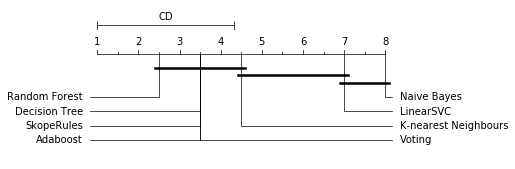

In [0]:
#draw the Nemenyi diagarm
alg_names = ["Decision Tree", "LinearSVC", "K-nearest Neighbours", "Naive Bayes", "SkopeRules", 
             "Random Forest", "Adaboost", "Voting"]
graph_ranks(avranks= avgrank, names = alg_names, cd = critical_diff)

Nemenyi test shows that RF, DT, SR, AD and VT are significantly better than LE and GNB.

### Bonferroni–Dunn test

In [0]:
import math

#calculate the critical difference between four algorithms
avgrank = [3.5,7.0,4.5,8.0,3.5,2.5,3.5,3.5]
b_critical_diff = compute_CD(avgrank, n = 10, test="bonferroni-dunn")
print("The critical difference between " + str(len(avgrank)) + " algorithms is + %f" % b_critical_diff)

The critical difference between 8 algorithms is + 2.946747


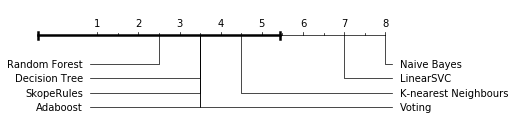

In [0]:
#draw the Nemenyi diagarm
alg_names = ["Decision Tree", "LinearSVC", "K-nearest Neighbours", "Naive Bayes", "SkopeRules", 
             "Random Forest", "Adaboost", "Voting"]
graph_ranks(avranks= avgrank, names = alg_names, cd = b_critical_diff, cdmethod=5)

Bonferroni–Dunn test using RF as control algorithm, we can generate similar conclusion as in Nemenyi test.

### Training and testing speed

The following figure illustrates that, despite poor classification performance, Naive Bayes algorithm is actually the fastest algorithm in terms of training and testing speed.

[Training and testing speed of models](https://drive.google.com/open?id=1JiXrvR0Kexw2UcYNFEcY0VjQmAXQa_0a)

The following figure provides a closer view of algorithms excluding Naive Bayes. Having the best classification performance, Random forest algorithm actually requires the longest time to build a model and test unseen data.

[Training and testing speed of models except Naive Bayes](https://drive.google.com/open?id=19py8B9t2itqRwiW2bHod5cUeiycQ4zht)

### Memory consumption rate

[memory consumption rate](https://drive.google.com/open?id=138O84s-LTeF8iQMz5mMNFojMzkxfk9Xb)

This figure illustrates that GNB algorithm needs the least memory to build a model. Similar as training/testing speed, RF algorithm  requires the most memory block than other seven algorithms.